In [ ]:
# Sentiment vs Trader Performance

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,4)

In [3]:
SENT_FILE = 'fear_greed_index.csv' 
TRADES_FILE = 'historical_data.csv'
OUT_DIR = Path('analysis_outputs')
OUT_DIR.mkdir(exist_ok=True)

In [4]:
def safe_read(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    
    # Try common formats
    if path.suffix.lower() in ['.csv', '.txt']:
        return pd.read_csv(path, low_memory=False)
    if path.suffix.lower() in ['.parquet', '.pq']:
        return pd.read_parquet(path)
    
    # Fallback
    return pd.read_csv(path, low_memory=False)

In [5]:
def find_column_like(df, keywords):
    keys = [k.lower() for k in keywords]
    for c in df.columns:
        low = c.lower()
        for k in keys:
            if k in low:
                return c
    return None

In [6]:
sent = safe_read(SENT_FILE)
trades = safe_read(TRADES_FILE)


print('Sentiment rows, cols:', sent.shape)
print('Trades rows, cols:', trades.shape)

Sentiment rows, cols: (2644, 4)
Trades rows, cols: (211224, 16)


In [7]:
print('\nSentiment head:')
print(sent.head())
print('\nTrades head:')
print(trades.head())


Sentiment head:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Trades head:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   

In [8]:
# Inspect columns and detect key fields
# - We want: date column in sentiment, classification column in sentiment,
# timestamp column in trades, and closed PnL (or realized PnL) in trades.

In [9]:
sent_date_col = find_column_like(sent, ['date','time','timestamp','day'])
sent_label_col = find_column_like(sent, ['class','sentiment','label','value','fear','greed'])
trades_time_col = find_column_like(trades, ['time','timestamp','date','datetime'])
trades_pnl_col = find_column_like(trades, ['pnl','closed','realized','profit','loss'])

In [10]:
print('Detected sentiment date column:', sent_date_col)
print('Detected sentiment label column:', sent_label_col)
print('Detected trades time column:', trades_time_col)
print('Detected trades pnl column:', trades_pnl_col)

Detected sentiment date column: timestamp
Detected sentiment label column: value
Detected trades time column: Timestamp IST
Detected trades pnl column: Closed PnL


In [12]:
# parse sentiment date
if sent_date_col is None:
    sent['Date_parsed'] = pd.to_datetime(sent.iloc[:,0], errors='coerce')
else:
    sent['Date_parsed'] = pd.to_datetime(sent[sent_date_col], errors='coerce', utc=True)


sent['date_only'] = sent['Date_parsed'].dt.date

In [13]:
# parse trades time
if trades_time_col is None:
    trades['Time_parsed'] = pd.to_datetime(trades.iloc[:,0], errors='coerce')
else:
    trades['Time_parsed'] = pd.to_datetime(trades[trades_time_col], errors='coerce', utc=True)


trades['trade_date'] = trades['Time_parsed'].dt.date


print('Parsed sample sentiment dates:')
print(sent[['Date_parsed','date_only']].head())
print('\nParsed sample trade dates:')
print(trades[['Time_parsed','trade_date']].head())

Parsed sample sentiment dates:
                          Date_parsed   date_only
0    1970-01-01 00:00:01.517463+00:00  1970-01-01
1 1970-01-01 00:00:01.517549400+00:00  1970-01-01
2 1970-01-01 00:00:01.517635800+00:00  1970-01-01
3 1970-01-01 00:00:01.517722200+00:00  1970-01-01
4 1970-01-01 00:00:01.517808600+00:00  1970-01-01

Parsed sample trade dates:
                Time_parsed  trade_date
0 2024-02-12 22:50:00+00:00  2024-02-12
1 2024-02-12 22:50:00+00:00  2024-02-12
2 2024-02-12 22:50:00+00:00  2024-02-12
3 2024-02-12 22:50:00+00:00  2024-02-12
4 2024-02-12 22:50:00+00:00  2024-02-12


In [14]:
# Normalize sentiment labels
# - Turn values like 'fear/greed index' into category labels: Fear, Greed, Neutral
# - If your sentiment file already has a classification column (like 'classification'), use it.

In [15]:
if sent_label_col is None:
    # choose a fallback (non-date column)
    possible = [c for c in sent.columns if c not in (sent_date_col, 'Date_parsed','date_only')]
    sent_label_col = possible[0]


sent['sent_class'] = sent[sent_label_col].astype(str).str.strip().str.title()
print('Sentiment class sample:')
print(sent[['Date_parsed', sent_label_col, 'sent_class']].head())

Sentiment class sample:
                          Date_parsed  value sent_class
0    1970-01-01 00:00:01.517463+00:00     30         30
1 1970-01-01 00:00:01.517549400+00:00     15         15
2 1970-01-01 00:00:01.517635800+00:00     40         40
3 1970-01-01 00:00:01.517722200+00:00     24         24
4 1970-01-01 00:00:01.517808600+00:00     11         11


In [16]:
# 8) Map daily sentiment to each trade

sent_map = sent.set_index('date_only')['sent_class'].to_dict()
trades['Sentiment'] = trades['trade_date'].map(sent_map).fillna('Unknown')


print('Mapped sentiments sample:')
print(trades[['trade_date','Sentiment']].drop_duplicates().head(20))

Mapped sentiments sample:
      trade_date Sentiment
0     2024-02-12   Unknown
44    2024-03-12   Unknown
189   2024-04-12   Unknown
190   2025-04-03   Unknown
211   2025-05-03   Unknown
220   2025-11-03   Unknown
224          NaT   Unknown
262   2025-08-04   Unknown
295   2025-09-04   Unknown
308   2025-10-04   Unknown
327   2025-12-04   Unknown
734   2024-12-12   Unknown
1052  2025-02-01   Unknown
1055  2025-03-01   Unknown
1061  2025-04-01   Unknown
1062  2025-05-01   Unknown
1070  2025-06-01   Unknown
1095  2025-09-01   Unknown
1238  2025-02-02   Unknown
1275  2025-04-02   Unknown


In [17]:
# 9) Ensure PnL numeric and create closedPnL column

if trades_pnl_col is None:
# try to find candidate numeric columns
    candidates = [c for c in trades.columns if np.issubdtype(trades[c].dtype, np.number)]
    if len(candidates)>0:
        trades_pnl_col = candidates[0]
        print('Fallback pnl column chosen:', trades_pnl_col)
    else:
        raise RuntimeError('No PnL-like column found in trades — edit the detection and re-run')


trades['closedPnL'] = pd.to_numeric(trades[trades_pnl_col], errors='coerce')
print('closedPnL sample:')
print(trades['closedPnL'].head())

closedPnL sample:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: closedPnL, dtype: float64


In [18]:
# Basic EDA: counts, PnL summary and win rates by sentiment

pnl_by_sent = trades.groupby('Sentiment')['closedPnL'].agg(n_trades='count', avg_pnl='mean', median_pnl='median', std_pnl='std').reset_index().sort_values('n_trades', ascending=False)
print('\nPnL by Sentiment:')
print(pnl_by_sent)


win_rate = trades.groupby('Sentiment').apply(lambda d: (d['closedPnL']>0).mean()).reset_index().rename(columns={0:'win_rate'})
print('\nWin rate by Sentiment:')
print(win_rate)


PnL by Sentiment:
  Sentiment  n_trades    avg_pnl  median_pnl     std_pnl
0   Unknown    211224  48.749001         0.0  919.164828

Win rate by Sentiment:
  Sentiment  win_rate
0   Unknown  0.411265


C:\Users\Admin\AppData\Local\Temp\ipykernel_21008\3044905708.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  win_rate = trades.groupby('Sentiment').apply(lambda d: (d['closedPnL']>0).mean()).reset_index().rename(columns={0:'win_rate'})


In [19]:
# Save summaries
pnl_by_sent.to_csv(OUT_DIR / 'pnl_by_sentiment.csv', index=False)
win_rate.to_csv(OUT_DIR / 'win_rate_by_sentiment.csv', index=False)

In [20]:
# Visualizations
# - Distribution of PnL by sentiment (violin-like or density), bar of avg PnL, time series aggregation.

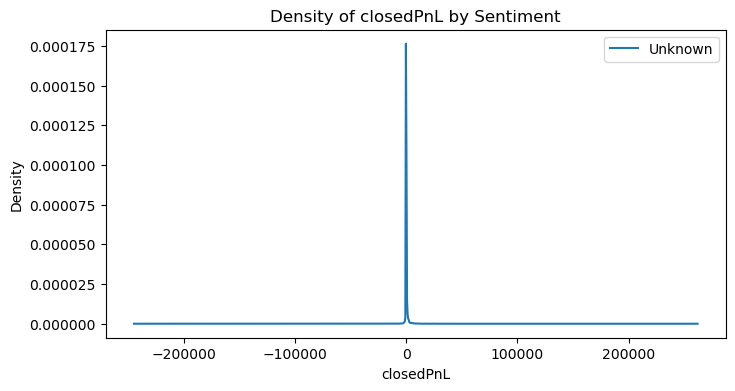

In [21]:
# Density plot overlayed
for s in pnl_by_sent['Sentiment'].tolist():
    subset = trades[trades['Sentiment']==s]['closedPnL'].dropna()
if len(subset) > 0:
    subset.plot(kind='kde', label=s)
plt.xlabel('closedPnL')
plt.title('Density of closedPnL by Sentiment')
plt.legend()
plt.show()

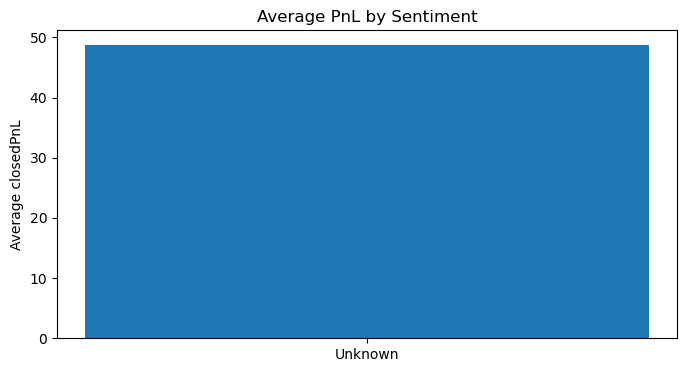

In [22]:
# avg PnL bar
plt.bar(pnl_by_sent['Sentiment'], pnl_by_sent['avg_pnl'])
plt.ylabel('Average closedPnL')
plt.title('Average PnL by Sentiment')
plt.show()

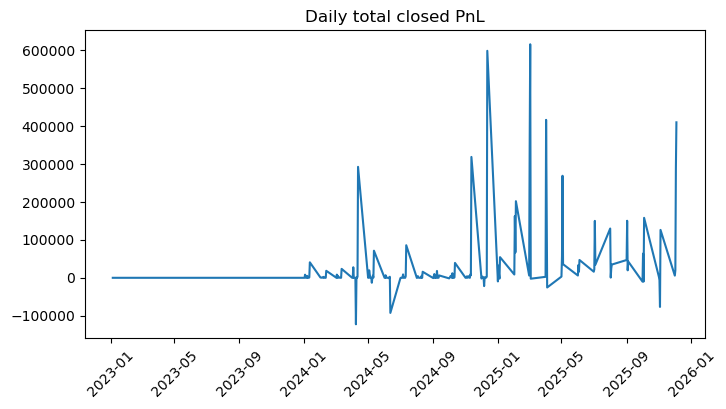

In [23]:
# time series aggregation: daily total pnl
daily = trades.groupby('trade_date')['closedPnL'].agg(total_pnl='sum', n_trades='count').reset_index()
plt.plot(daily['trade_date'], daily['total_pnl'])
plt.xticks(rotation=45)
plt.title('Daily total closed PnL')
plt.show()

In [24]:
# Statistical tests
# - Greed vs Fear mean PnL (Welch's t-test), plus Mann-Whitney as robust check.

if ('Greed' in trades['Sentiment'].values) and ('Fear' in trades['Sentiment'].values):
    g = trades[trades['Sentiment']=='Greed']['closedPnL'].dropna()
    f = trades[trades['Sentiment']=='Fear']['closedPnL'].dropna()
    print('Greed n, Fear n:', len(g), len(f))
    if len(g) >= 10 and len(f) >= 10:
        t = stats.ttest_ind(g, f, equal_var=False, nan_policy='omit')
        mw = stats.mannwhitneyu(g, f, alternative='two-sided')
        print('Welch t-test:', t)
        print('Mann-Whitney U:', mw)
    else:
        print('Not enough samples for reliable tests')
else:
    print('Greed and/or Fear label not present — check sentiment mapping')

Greed and/or Fear label not present — check sentiment mapping


In [25]:
# Per-account and per-symbol summaries
# - Useful to identify players whose performance changes with sentiment

acct_col = find_column_like(trades, ['account','acct','user','client'])
if acct_col:
    acct_stats = trades.groupby(acct_col).agg(n_trades=('closedPnL','count'), total_pnl=('closedPnL','sum'), avg_pnl=('closedPnL','mean'), win_rate=('closedPnL', lambda x: (x>0).mean())).reset_index().sort_values('n_trades', ascending=False)
    acct_stats.head(20).to_csv(OUT_DIR / 'account_summary.csv', index=False)
    print('Top accounts (by trades):')
    print(acct_stats.head(10))
else:
    print('Account-like column not detected')   


sym_col = find_column_like(trades, ['symbol','ticker','pair'])
if sym_col:
    sym_stats = trades.groupby(sym_col).agg(n_trades=('closedPnL','count'), avg_pnl=('closedPnL','mean'), win_rate=('closedPnL', lambda x: (x>0).mean())).reset_index().sort_values('n_trades', ascending=False)
    sym_stats.to_csv(OUT_DIR / 'symbol_summary.csv', index=False)
    print('Per-symbol top rows:')
    print(sym_stats.head())
else:
    print('Symbol-like column not detected')

Top accounts (by trades):
                                       Account  n_trades     total_pnl  \
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab     40184  8.360806e+05   
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864     21192  9.401638e+05   
23  0xa0feb3725a9335f49874d7cd8eaad6be45b27416     15605  1.063029e+05   
21  0x8477e447846c758f5a675856001ea72298fd9cb5     14998  4.391701e+04   
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23     14733  2.143383e+06   
3   0x28736f43f1e871e6aa8b1148d38d4994275d72c4     13311  1.324648e+05   
13  0x513b8629fe877bb581bf244e326a047b249c4ff1     12236  8.404226e+05   
17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4      9893  3.790954e+05   
10  0x47add9a56df66b524d5e2c1993a43cde53b6ed85      8519  1.033437e+05   
12  0x4f93fead39b70a1824f981a54d4e55b278e9f760      7584  3.089759e+05   

       avg_pnl  win_rate  
31   20.806305  0.428230  
29   44.364091  0.467582  
23    6.812104  0.345787  
21    2.928191  0.261968  
27  145.481748  0.337134

In [26]:
# Simple predictive model (profitability classification)
# - Prepare a lightweight feature set and train a logistic regression as a baseline.

if trades['closedPnL'].notnull().sum() >= 100:
    dfm = trades.copy()
    dfm['profit_label'] = (dfm['closedPnL'] > 0).astype(int)
    side_col = find_column_like(trades, ['side','direction'])
    lev_col = find_column_like(trades, ['leverage','lev'])
    size_col = find_column_like(trades, ['size','qty','quantity','amount','volume'])


    dfm['side_buy'] = 0
    if side_col:
        dfm['side_buy'] = dfm[side_col].astype(str).str.lower().str.contains('buy').astype(int)
        dfm['leverage_num'] = pd.to_numeric(dfm[lev_col], errors='coerce').fillna(1) if lev_col else 1
        dfm['size_num'] = pd.to_numeric(dfm[size_col], errors='coerce').fillna(0) if size_col else 0
        dfm['sent_greed'] = (dfm['Sentiment']=='Greed').astype(int)
        dfm['sent_fear'] = (dfm['Sentiment']=='Fear').astype(int)


    features = ['side_buy','leverage_num','size_num','sent_greed','sent_fear']
    dfm = dfm[features + ['profit_label']].dropna()


    if len(dfm) >= 100:
        X = dfm[features]; y = dfm['profit_label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        model = LogisticRegression(max_iter=500)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test); y_proba = model.predict_proba(X_test)[:,1]
        print('ROC AUC:', roc_auc_score(y_test, y_proba))
        print('Classification report:')
        print(classification_report(y_test, y_pred, digits=4))
        coef_df = pd.DataFrame({'feature':features, 'coef':model.coef_.flatten()})
        print(coef_df)
    else:
        print('Not enough rows after feature extraction for modeling')
else:
    print('Not enough closedPnL-labelled trades to model')

ROC AUC: 0.6269261334130977
Classification report:
              precision    recall  f1-score   support

           0     0.7254    0.6006    0.6571     31089
           1     0.5412    0.6745    0.6005     21717

    accuracy                         0.6310     52806
   macro avg     0.6333    0.6375    0.6288     52806
weighted avg     0.6496    0.6310    0.6339     52806

        feature          coef
0      side_buy -1.141376e+00
1  leverage_num  8.282271e-02
2      size_num -5.798388e-08
3    sent_greed  0.000000e+00
4     sent_fear  0.000000e+00


In [27]:
# Save final artifacts and brief report
# - The notebook already saves CSV summaries to `analysis_outputs/`.
# - When ready, export notebook as PDF for the hiring submission.

print('Done. Check the', OUT_DIR, 'folder for summary CSVs and saved artifacts.')

Done. Check the analysis_outputs folder for summary CSVs and saved artifacts.
